Будем пытаться научить модель предсказывать по тексту комментария рейтинг который пользователь поставил вину.

In [193]:
!pip install validators

In [194]:
import numpy as np
import pandas as pd

df = pd.read_csv("data_comms.csv")
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()
df

,comment,rating
0,"Приятный вкус, мне понравилось.",5.0
1,"Год урожая 2022, дата розлива 27.09.23. Ранее ...",2.0
2,"Покупала на новый год ,была разочарована сильн...",2.0
3,"Покупаем это вино постоянно,нам нравится.",5.0
4,"Сладковатый вкус, взвешенные частички, осадок....",3.0
...,...,...
16333,Мондоро это бренд.Тут и говорить нечего.Никаки...,4.5
16334,Почитав отзывы ожидал большего... Напомнило вк...,3.0
16335,"Никакого фруктового оттенка,кислятина за 200р....",1.0
16336,Очень понравилось Мондоро Брют! Рекомендую,5.0


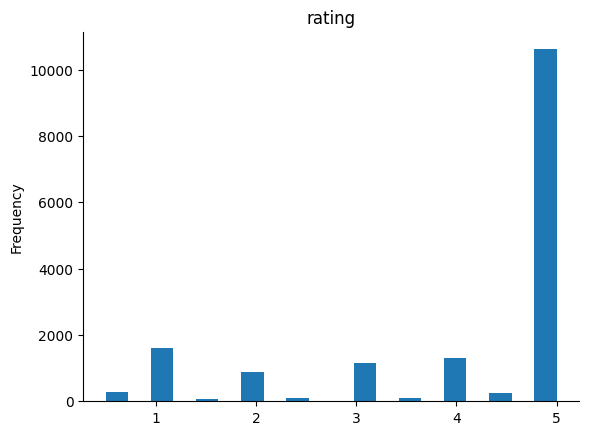

In [195]:
from matplotlib import pyplot as plt
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

На гистограмме видим, что комментариев с оценкой *.5 совсем мало. В целом нам эта точность между ценками в 0.5 неважна, так что округлим эти значения в большную сторону.

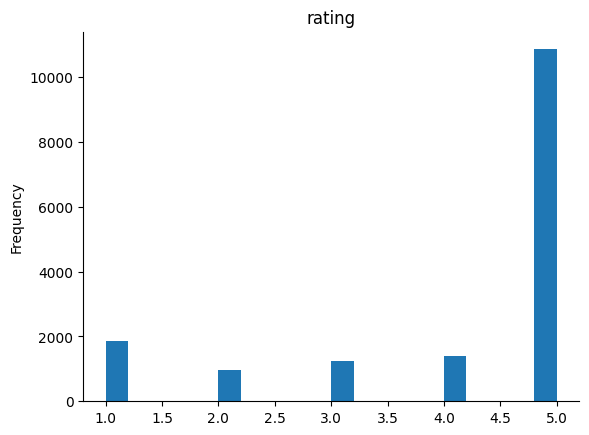

In [196]:
import math
df['rating'] = df['rating'].apply(math.ceil)
df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

Всё ещё плохо, давайте попробуем оверсемплить.

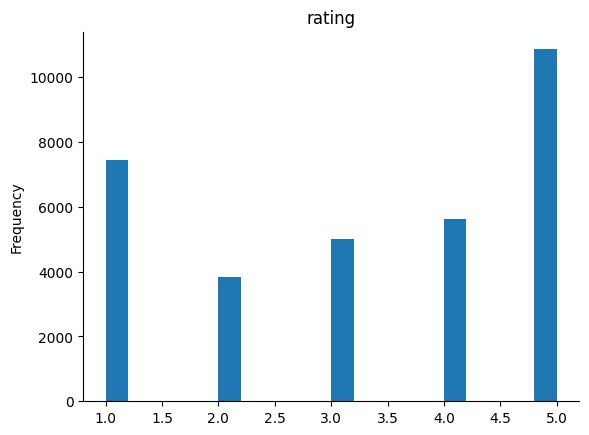

In [197]:
for i in range(1, 5):
  df_ = df.query(f"rating == {i}")
  #print(i, len(df_.axes[0]))
  df = pd.concat([df, df_, df_, df_], ignore_index=True)


df['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

Теперь удалим стоп-слова, применим стемминг.

In [198]:
import nltk
from nltk import stem
from nltk.corpus import stopwords
import re
import validators

nltk.download("stopwords")
stemmer = stem.SnowballStemmer('russian')
stopwords = set(stopwords.words('russian'))

def preprocess(text):
  try:
    text = text.lower()
    copy = text
    text = []
    copy = copy.split(" ")
    for word in copy:
      if not validators.url(word) and word[0] != '#':
        word = re.sub(r'[^\w\s]', '', word)
        if (word not in stopwords) and (word.isalpha()):
          text.append(stemmer.stem(word))
    text = (' '.join(text))
    return text
  except Exception as e:
    print(e)
    print(text)

text = df.iloc[1]['comment']
print(text)
preprocess(text)

Год урожая 2022, дата розлива 27.09.23. Ранее использовали Саперави из Прикумья Юга Ставропольского края, розлив Адыгея - был вполне достойный напиток. Сейчас виноматериал Саперави указаный на контэтикетке: Краснодарский и Ставропольский края, Крым (на сайте КиБ Прикумье, обман), розлв Адыгея. Мутная, спиртово-горькая жижа, ни носа ни вкуса НЕТ совсем.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'год урож дат розлив ран использова саперав прикум юг ставропольск кра розл адыге вполн достойн напиток виноматериа саперав указан контэтикетк краснодарск ставропольск кра крым сайт киб прикум обма розлв адыге мутн спиртовогорьк жиж нос вкус'

In [199]:
df['comment'] = df['comment'].apply(preprocess)
df

,comment,rating
0,приятн вкус понрав,5
1,год урож дат розлив ран использова саперав при...,2
2,покупа нов год разочарова сильнопарт плох видн...,2
3,покупа эт вин постояннон нрав,5
4,сладковат вкус взвешен частичк осадок пьет лег...,3
...,...,...
32765,общемт неплох напиток пит хот итальянск игрист...,4
32766,помн лет мор пил вин местн так доброд кондиц с...,4
32767,сво ценов категор довольн плох пузырьк прям за...,4
32768,плох вкус голов болел,4


Токенизируем с помощью byte-pair encoding, чтобы сократиь размер словаря.

In [200]:
from sklearn.model_selection import train_test_split
from tokenizers import ByteLevelBPETokenizer

X = df['comment']
y = df['rating']

tokenizer = ByteLevelBPETokenizer()
tokenizer.train_from_iterator(X, vocab_size=10000, min_frequency=2)
X = X.apply(lambda x: tokenizer.encode(x).tokens)
X = X.apply(lambda x: " ".join(x))

Трансформируем строки в tgidf-вектора

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

Обучим линейный классификатор и выведем метрики.

In [202]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LinearSVC(multi_class="ovr")
model.fit(X=X_train, y=y_train.values)

prediction = model.predict(X_test)
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n")
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}")

Test Set Accuracy : 71.65090021361002 %


Classification Report : 

              precision    recall  f1-score   support

           1       0.73      0.81      0.77      1473
           2       0.70      0.53      0.60       769
           3       0.68      0.67      0.67       981
           4       0.70      0.62      0.66      1108
           5       0.74      0.79      0.76      2223

    accuracy                           0.72      6554
   macro avg       0.71      0.68      0.69      6554
weighted avg       0.71      0.72      0.71      6554



И наконец проведем кросс-валидацию, чтобы посмотреть насколько переобучается модель.

In [203]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

cv = ShuffleSplit(n_splits=5, test_size=0.2)
my_scores = cross_validate(model, X, y, cv=cv, scoring = ('balanced_accuracy', 'f1_weighted'), return_train_score=True)

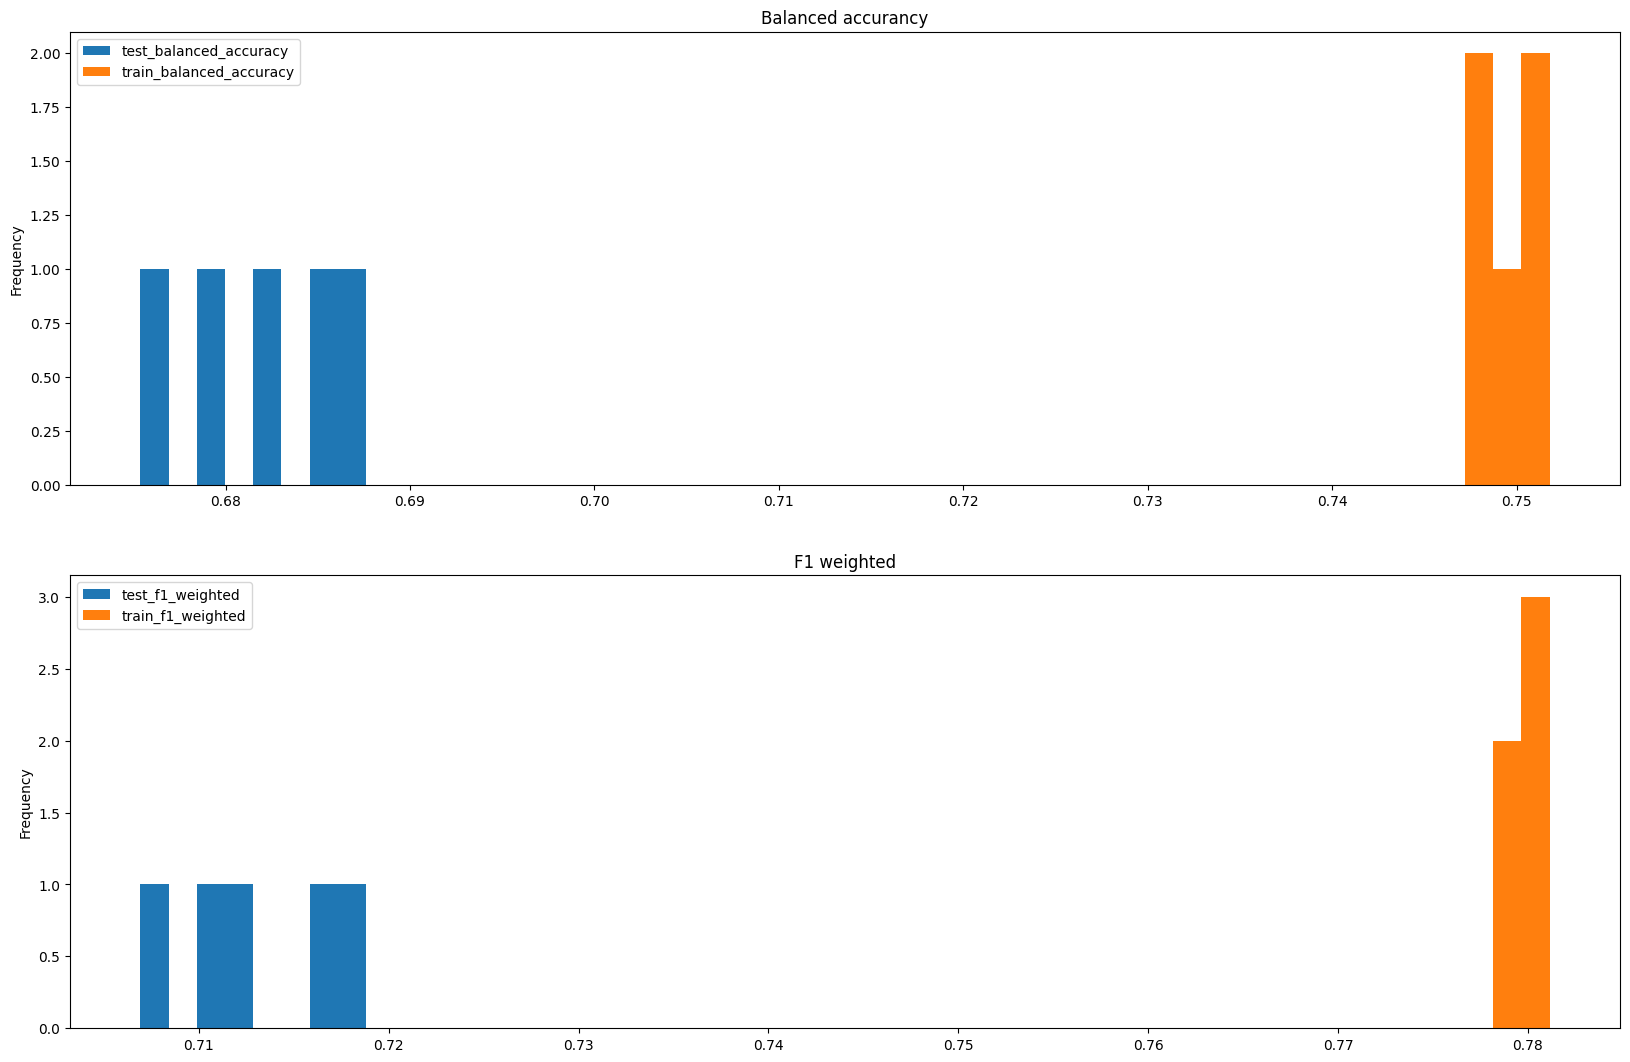

In [204]:
myDf = pd.DataFrame(my_scores)
fig = plt.figure(figsize=(20, 20))
myDf[['test_balanced_accuracy', 'train_balanced_accuracy']].plot.hist(bins=50, ax = fig.add_subplot(3,1,1), title = "Balanced accurancy")
myDf[['test_f1_weighted', 'train_f1_weighted']].plot.hist(bins=50, ax = fig.add_subplot(3,1,2), title = "F1 weighted")
fig.show()

Как видно по гистограммам немного переобучения присутствует, но в целом разница метрик небольшая.